In [21]:
import sys, os
import logging
if __name__ == '__main__':
    ddir = os.path.dirname(os.path.abspath(""))
    while "autochem" not in os.listdir(ddir):
        ddir = os.path.dirname(ddir)
    sys.path.insert(0, ddir)
    sys.path.append(ddir)
from autochem.spectra.nmr.reader import read_nmr, NMRReadError
logging.basicConfig()
from matplotlib import pyplot as plt

In [22]:
logger = logging.getLogger("autochem")
logger.setLevel("DEBUG")

In [23]:
FOLDER = "C:\\Users\\be34gof\\Downloads\\autonmr\\20220202115053"

In [24]:
def find_nmrs(root, path_only=False, skip_path=None):
    for path, folder, files in os.walk(root):
        if skip_path is not None:
            if skip_path(path):
                continue
        try:
            data, udict = read_nmr(path, preprocess=True)
            logger.info("read '{}' as '{}'".format(path, udict["datatype"]))
            if path_only:
                yield path
            else:
                udict["path"] = path
                yield (data, udict)
        except NMRReadError:
            pass

In [258]:
import nmrglue.process.proc_autophase
import nmrglue as ng
import numpy as np
from scipy.optimize import minimize
def work_spec(data, data_dict, path):
    processing=[]
    ppm_scale = data_dict["ppm_scale"]
    data=data_dict["raw_data"]
    data = ng.proc_base.fft(data)[::-1]
    data=data-np.median(data)
    data=data/data.max()
    plt.plot(ppm_scale,data)

    #plt.xlim(-42,-37)
    #plt.show()
    #plt.close()
    def phascecorr(r,data):
        p0,p1=r
        nd = nmrglue.proc_base.ps(data, p0=p0,p1=p1)
        nd=ng.proc_base.di(nd)
        nd=nd-np.median(nd)
        nd=nd/nd.max()
        negsum=- nd[nd<0].sum()
        return negsum
    
    
    r=[-100,-100]
    print(r)
    for i in range(2):
        _min = minimize(phascecorr,
                       r,
                       (data),
                       method = 'Nelder-Mead',
                     #  bounds=bounds
                       )
        r=_min["x"]
        print(r)
    
    print(r)
    nd = nmrglue.proc_base.ps(data, p0=r[0], p1=r[1])
    nd=ng.proc_base.di(nd)
    nd=nd-np.median(nd)
    nd=nd/nd.max()
    plt.plot(ppm_scale,nd)
    plt.xlim(-42,-37)
    plt.show()
    plt.close()
    

INFO:autochem:read 'C:\Users\be34gof\Downloads\autonmr\20220202115053\00098' as 'magritek'
C:\Users\be34gof\Syn\programming\envs\autochem\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-100, -100]
[  6.6545781  -14.70332686]
[  6.65392552 -14.71037973]
[  6.65392552 -14.71037973]


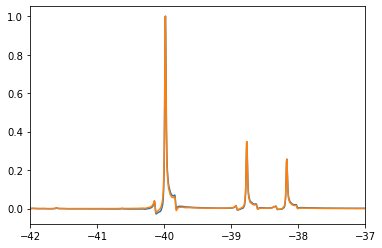

In [261]:

for i,(data, data_dict) in enumerate(find_nmrs(FOLDER,skip_path=lambda p: not p.endswith("00098"))):
    path = data_dict["path"]
    sdf = work_spec(data, data_dict, path)
    break

In [325]:
def moving_average(a, n=3) :
        n=min(n,a.shape[0])
        a=a.copy()
        ret = np.cumsum(np.nan_to_num(a), dtype=float,axis=0)
        starts = (ret!=0).argmax(0)
        starts[ret[starts,np.arange(starts.shape[0])]==0]=a.shape[0]
        for i,s in enumerate(starts):
            a[:s,i]=a[s,i]
        ret = np.cumsum(np.nan_to_num(a), dtype=float,axis=0)
        
        ret[n:] = ret[n:] - ret[:-n]
        ret[n - 1:]/=n
        if n>1:
            ret[:n - 1]=(ret[:n - 1].T/np.arange(1,n)).T
        for i,s in enumerate(starts):
            ret[:s,i]=np.nan
        return ret

In [326]:
l=50
s=5
za = np.zeros((s,l))*np.nan
si = np.random.randint(int(l/2),size=s)
for j,i in enumerate(si):
    za[j,i:]= np.arange(0,l-i)/10+j
#(za!=0).argmax(1)

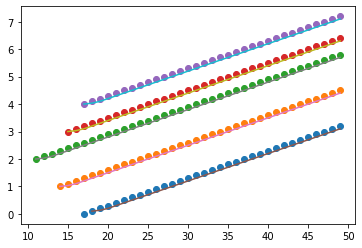

In [327]:
plt.plot(za.T,"o")
plt.plot(moving_average(za.T))

In [321]:
moving_average(za.T)

array([[0.1       , 1.        , 2.        , 3.        , 4.        ],
       [0.1       , 1.        , 2.        , 3.        , 4.        ],
       [0.1       , 1.        , 2.        , 3.        , 4.        ],
       [0.1       , 1.        , 2.        , 3.        , 4.        ],
       [0.1       , 1.        , 2.        , 3.        , 4.        ],
       [0.1       , 1.        , 2.        , 3.        , 4.        ],
       [0.1       , 1.        , 2.        , 3.        , 4.        ],
       [0.1       , 1.        , 2.        , 3.        , 4.        ],
       [0.13333333, 1.        , 2.        , 3.        , 4.        ],
       [0.2       , 1.        , 2.        , 3.        , 4.        ],
       [0.3       , 1.        , 2.        , 3.        , 4.        ],
       [0.4       , 1.        , 2.        , 3.        , 4.        ],
       [0.5       , 1.03333333, 2.        , 3.        , 4.        ],
       [0.6       , 1.1       , 2.        , 3.        , 4.        ],
       [0.7       , 1.2       , 2.

In [33]:
import pandas as pd
import datetime
df=pd.DataFrame()
nindx = ['startTime',"delta_time", "peak"]
for t in range(10):
    d=datetime.datetime.now()-datetime.timedelta(seconds=t*59)
    sdf = pd.DataFrame([{"startTime":d,"peak":p} for p in [1,2,3] ])
    sdf.set_index([ix for ix in nindx if ix in sdf.columns], inplace=True)
    df = pd.concat([df, sdf[~sdf.index.isin(df.index)]])
    
df.sort_values("startTime",inplace=True)
df = df.reset_index()
df["delta_time"]=(df["startTime"]-df.iloc[0]["startTime"])
df["delta_time"] = df["delta_time"].apply(lambda d: d.total_seconds())
df.set_index(nindx, inplace=True)
display(df)

In [126]:
import numpy as np
SPECIES_PEAKS = [[3.9,3.77], [4.12], [4.3], [4.5],[2.7]]

peak_targets=np.array([2.4,3.8,4.43,10])
detected_peak_ranges=np.array([[2.2,2.75],[3.6,3.9],[4.4,4.7],[9,11]])

flatted_specie_peaks=[]
flatted_specie_peaks_indices=[]
for i,pl in enumerate(SPECIES_PEAKS):
    flatted_specie_peaks.extend(pl)
    flatted_specie_peaks_indices.extend([i]*len(pl))
flatted_specie_peaks=np.array(flatted_specie_peaks)
flatted_specie_peaks_indices=np.array(flatted_specie_peaks_indices)

targets={}

#flatted_specie_peaks,flatted_specie_peaks_indices
diff_matrix = np.abs(np.subtract.outer(flatted_specie_peaks,peak_targets))
sorted_indices=[]
while np.any(~np.isnan(diff_matrix)):
    induices =np.unravel_index(np.nanargmin(diff_matrix), diff_matrix.shape)
    sorted_indices.append(induices)
    diff_matrix[induices]=np.nan
sorted_indices=np.array(sorted_indices).astype(float)

targets={}

while sorted_indices.shape[0]>0:
    sorted_indices=sorted_indices[~np.isnan(sorted_indices)].reshape(-1,2)
    found=False
    for i,(ix1,ix2) in enumerate(sorted_indices):
        ix1=int(ix1)
        ix2=int(ix2)
        species_peak=flatted_specie_peaks[ix1]
        target_peak=peak_targets[ix2]
        dec_range=detected_peak_ranges[ix2]
        if dec_range[0]<=species_peak and dec_range[1]>=species_peak:
            found=True
            targets[target_peak]=ix1
            print("indices",ix1,ix2,"species_peak",species_peak,"target_peak",target_peak,dec_range)
            sorted_indices[i,:]=np.nan
            break
            
    if not found:
        sorted_indices[:]=np.nan
        
    if sorted_indices.shape[0]==0:
        break

print(targets)


{p:(SPECIES_PEAKS[flatted_specie_peaks_indices[targets.get(p)]] if targets.get(p) is not None else "") for p in peak_targets}
#for k,v in targets.items():
#    print(peak_targets[k],SPECIES_PEAKS[flatted_specie_peaks_indices[v]])



indices 1 1 species_peak 3.77 target_peak 3.8 [3.6 3.9]
indices 4 2 species_peak 4.5 target_peak 4.43 [4.4 4.7]
indices 0 1 species_peak 3.9 target_peak 3.8 [3.6 3.9]
indices 5 0 species_peak 2.7 target_peak 2.4 [2.2  2.75]
{3.8: 0, 4.43: 4, 2.4: 5}


{2.4: [2.7], 3.8: [3.9, 3.77], 4.43: [4.5], 10.0: ''}

In [179]:
x=np.arange(10000)/100
peaks=np.array([700,800])
peak_ranges=[[19,30.744],[1,9]]
peak_ranges=np.array(peak_ranges)


if peak_ranges is not None:
        peak_ranges=np.array(peak_ranges)
        assert peak_ranges.shape[1]==2
        peak_ranges=peak_ranges[peak_ranges[:, 0].argsort()]
        assert not np.any(np.diff(peak_ranges.flatten())<0),"overlap in peak ranges"
        
if x is not None and peak_ranges is not None:
    us = np.abs(np.subtract.outer(peak_ranges,x))
    peak_ranges = us.argmin(-1)
    

for i,p in enumerate(peaks):
    ranges=(p >=peak_ranges[:,0])&(p <=peak_ranges[:,1])
    ranei=ranges.argmax()
    print(ranei,peak_ranges[ranei])

0 [100 900]
0 [100 900]


In [168]:
peak_ranges[0]

array([100, 900], dtype=int64)